In [1]:
##########==========##########==========##########==========##########==========

# H - Header

#### H1 - Libraries

In [2]:
## standard foundational libraries
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

## import specific functions
from matplotlib.colors  import hsv_to_rgb, to_hex
from os                 import mkdir, listdir
from os.path            import isfile, isdir
from datetime           import datetime, timedelta
from cartopy            import feature
from cartopy.crs        import LambertConformal, PlateCarree
from dbfread            import DBF
from docx               import Document
from textwrap           import fill as txt_wrap
from geopy.distance     import geodesic
from ipyparallel        import Cluster
from sklearn.cluster    import AgglomerativeClustering
from functools          import partial

from scipy.spatial      import Voronoi
from shapely.geometry   import Polygon
from shapely.ops        import unary_union
from shapely.validation import make_valid

#### H2 - Basic Automation

In [3]:
## set up standard directories if needed
def make_standard_file_system():
    for i in ['A_Input', 'B_Intermediate', 'C_Output']:
        if not isdir(i): mkdir(i)

## log time elapsed
time_log = dict()
def log_time(the_id = 'End Log'):
    
    ## construct new time stamp
    now_time = str(datetime.now().hour).zfill(2)
    now_time = now_time +':'+ str(datetime.now().minute).zfill(2)
    now_time = now_time +':'+ str(datetime.now().second).zfill(2)

    ## add to time log
    if the_id == 'End Log':
        time_log['End'] = now_time
        print('Time log:')
        for i in time_log.keys():
            print(i.rjust(5) + ':', time_log[i])
    else:
        time_log[the_id] = now_time
        
## toggle cache versus build
def build_or_cache(function, address, permit):
    if permit and isfile(address):
        print('Build/Cache Decision: Cache')
        the_file = pd.read_csv(address, index_col = 0)
    else:
        print('Build/Cache Decision: Build')
        the_file = function()
        the_file.to_csv(address)
    return the_file
    
## execute functions
make_standard_file_system()
log_time('H2')

#### H3 - Settings

In [4]:
## set color palette
set_color = {
    'AzureDark'    :(7/12, 1.0, 0.4),
    'AzureMedium'  :(7/12, 0.7, 0.7),
    'AzureLight'   :(7/12, 0.4, 1.0),
    'AzureBG'      :(7/12, 0.1, 1.0),
    
    'OrangeDark'   :(1/12, 1.0, 0.4),
    'OrangeMedium' :(1/12, 0.7, 0.7),
    'OrangeLight'  :(1/12, 0.4, 1.0),
    'OrangeBG'     :(1/12, 0.1, 1.0)
    }

for i in set_color.keys(): set_color[i] = to_hex(hsv_to_rgb(set_color[i]))
set_color['AzureOverlay']  = set_color['AzureBG'] + '80'
set_color['OrangeOverlay'] = set_color['AzureBG'] + '80'

## set font sizes
set_font = {
    'small' : 16,
    'medium': 24,
    'large' : 32
    }

## time-saver settings
set_acceleration = {
    'dbf_cache'             : True,
    'sample_size'           : 1/16,
    'pop_cache'             : True,
    'distance_cache'        : True,
    'cluster_parallel_cores': 6,
    'cluster_L1_cache'      : True,
    'cluster_L2_cache'      : True
    }

## map parameters
set_map = {
    'bounds'  : [-124.73 + 5, -66.95 - 5, 25.12 - 3.3, 49.38 + 3.3],
    'map_proj': LambertConformal(
        central_longitude = (-124.73 - 66.95) / 2,
        central_latitude = (25.12 + 49.38) / 2,
        standard_parallels = (25.12, 49.38))
    }
log_time('H3')

# GD - Gather Data / RD - Refine Data

#### GD1 - read census tract geographic data

In [5]:
def read_geo_data(directory = 'A_Input/tracts_dbf'):
    
    ## list dbf files in target directory
    dbf_addr = listdir(directory)
    dbf_addr = [i for i in dbf_addr if i[-3::] == 'dbf']
    
    ## define relevant columns from each
    desired_columns = {'GEOID': str,
                       'STATEFP': str, 'COUNTYFP':str, 'TRACTCE':str,
                        'INTPTLAT': float, 'INTPTLON': float, 'ALAND': int}
    
    ## read in all dbf files
    dbf_data = []
    for i in dbf_addr:
        i_dbf = pd.DataFrame(iter(DBF(directory + '/' + i)))
        i_dbf = i_dbf[desired_columns.keys()].astype(desired_columns)
        dbf_data.append(i_dbf)
        
    ## compile data into a single file
    dbf_data = pd.concat(dbf_data, axis = 0).sort_values('GEOID')
    dbf_data['count'] = 1
    dbf_data = dbf_data.reset_index(drop = True)
    
    ## repair GEOID irregularities
    dbf_data['GEOID'] = dbf_data['GEOID'].astype(str).str.zfill(11)
    
    ## export data
    return dbf_data

## execute code
geo_data = build_or_cache(function = read_geo_data,
                          address = 'B_Intermediate/dbf_data.csv.gz',
                          permit = set_acceleration['dbf_cache'])
log_time('GD1')

Build/Cache Decision: Cache


#### RD1 - draw a sample from the census tract geographic data and exclude outlier tracts

In [6]:
def refine_geo_data(dat = geo_data, too_rural = 20.720e6 * 5,
                    too_much = set_acceleration['sample_size']):
    
    ## filter out extremely rural areas (< 100 people per square mile)
    dat = dat.loc[dat.ALAND < too_rural, :]
    
    ## take systematic sample of the data
    i = np.arange(0, dat.shape[0]) % int(1 / too_much)
    dat = dat.loc[i == 0, ]
    
    ## set index
    dat = dat.rename({'GEOID':'GEO_ID'}, axis = 1).set_index('GEO_ID')
    dat.index = 'ct' + dat.index.astype(str).str.zfill(11)

    ## return data
    return dat

## execute code
geo_data = refine_geo_data()
log_time('RD1')

#### GD2 - read population data

In [7]:
def read_pop_data(roster = 'A_Input/sources.csv'):
    
    ## read in data file roster
    roster = pd.read_csv(roster).set_index('OBJ_NAME')
    
    ## load all datasets in the roster file
    pop_data = dict()
    for i in roster.index:
        var_names = roster.loc[i, 'VAR_NAME'].split(';')
        pop_data[i] = pd.read_csv('A_Input' + '/' + roster.loc[i, 'FILE_NAME'],
            usecols = var_names, dtype = str)
        
    ## merge census datasets
    census_i = roster.index[roster.SOURCE == 'data.census.gov'].values
    census_dat_count = 0
    
    for i in census_i:
        pop_data[i] = pop_data[i].loc[1::, :].set_index('GEO_ID')
        if census_dat_count < 1:
            pop_data['census'] = pop_data[i]
            pop_data.pop(i)
            census_dat_count += 1
        else:
            pop_data['census'] = pop_data['census'].join(pop_data[i])
            pop_data.pop(i)
            census_dat_count += 1
            
    ## convert census data to numeric
    def robust_int(x):
        try: x = int(x)
        except: x = 0
        return x
    map_robust_int = lambda x: x.map(robust_int)
    pop_data['census'] = pop_data['census'].apply(map_robust_int)

    return pop_data

## execute code - see RD2

#### RD2 - refine and compile population data

In [8]:
def refine_pop_data(pop):
    
    ## -- standardize geographic codes as needed
    state_fips = pop.pop('state_fips')# if needed in future; not currently used
    pop['census'].index = pop['census'].index.str.replace('1400000US', '')

    ## -- refine life expectancy data and merge into census data
    pop['lifespan'].columns = ['GEO_ID', 'life_expect']
    pop['lifespan'].life_expect = pop['lifespan'].life_expect.astype(float)
    pop['census'] = pop['census'].join(pop['lifespan'].set_index('GEO_ID'))
    pop.pop('lifespan')
    
    ## -- refine voting data
    
    ## filter to necessary data
    i = (pop['vote'].party == 'REPUBLICAN') & (pop['vote'].year == '2020')
    pop['vote'] = pop['vote'].loc[i].drop(['year', 'party', 'state_po'],
                                          axis = 1)
    
    ## impute total votes (data is irregular from state to state)
    temp = pop['vote'].copy()
    temp = temp.drop(['totalvotes'], axis = 1)
    temp = temp.set_index(['county_fips', 'mode']).astype(int).reset_index()
    temp = temp.groupby(['county_fips', 'mode']).sum().reset_index()
    total_vote = temp.loc[temp['mode'] == 'TOTAL'].set_index('county_fips')
    total_vote = total_vote.drop('mode', axis = 1)
    seg_vote = temp.loc[temp['mode'] != 'TOTAL'].groupby('county_fips').sum()
    total_vote = pd.concat({'Total': total_vote, 'Alt': seg_vote}, axis = 1)
    total_vote = total_vote.max(axis = 1)
    total_vote = pd.DataFrame({'repvotes':total_vote})
    pop['vote'] = pop['vote'].join(total_vote, on = 'county_fips')
    pop['vote'] = pop['vote'].drop_duplicates('county_fips')
    pop['vote'] = pop['vote'].drop(['mode', 'candidatevotes'], axis = 1)
    del seg_vote, temp, total_vote
    
    ## calculate percentage voting republican
    pop['vote'] = pop['vote'].set_index('county_fips').astype(float)
    pop['vote']['reppct'] = pop['vote']['repvotes'] / pop['vote']['totalvotes']
    
    ## calculate percentage of population that voted
    county_total = pd.DataFrame(pop['census']['DP05_0001E'])
    county_total['county'] = [i[0:5] for i in county_total.index]
    county_total = county_total.groupby('county').sum().astype(int)
    pop['vote'] = pop['vote'].join(county_total)
    pop['vote']['totalpct'] = pop['vote']['totalvotes'] / pop['vote']['DP05_0001E']
    pop['vote'].loc[pop['vote'].totalpct > 1, 'totalpct'] = 159633396 / 331449281
    pop['vote'] = pop['vote'][['reppct', 'totalpct']]
    
    ## merge voting data into census and convert to counts
    pop['census']['county'] = [i[0:5] for i in pop['census'].index]
    pop['census'] = pop['census'].reset_index().set_index('county').join(pop['vote'])
    pop = pop['census'].set_index('GEO_ID')
    pop['state'] = [i[0:2] for i in pop.index]
    
    ## -- impute missing data
    
    ## impute at the state level
    state_mean = pop.copy()[['life_expect', 'reppct', 'totalpct', 'state']]
    state_mean = state_mean.groupby('state').mean().round(2)
    state_mean = state_mean.loc[pop.state]
    for i in state_mean.columns:
        j = pop[i].isna().values
        pop.loc[j, i] = state_mean.loc[j, i].values
    
    ## impute at the national level
    for i in state_mean.columns:
        j = pop[i].isna().values
        pop.loc[j, i] = pop[i].mean()
    del state_mean
    
    ## convert vote proportions to counts
    pop['rep_vote'] = pop['reppct'] * pop['totalpct'] * pop['DP05_0001E']
    pop['rep_vote'] = pop['rep_vote'].round().astype(int)
    pop['total_vote'] = (pop['totalpct'] * pop['DP05_0001E']).round().astype(int)
    pop = pop.drop(['reppct', 'totalpct', 'state'], axis = 1).round(1)
    
    ## add prefix to GEO_ID
    pop.index = 'ct' + pop.index.astype(str).str.zfill(11)
    
    ## export result
    return pop

def read_refine_pop_data():
    pop_data = read_pop_data()
    pop_data = refine_pop_data(pop = pop_data.copy())
    return pop_data
    

## execute code
pop_data = build_or_cache(function = read_refine_pop_data,
    address = 'B_Intermediate/pop_data.csv.gz',
    permit = set_acceleration['pop_cache'])
log_time('RD2')

Build/Cache Decision: Cache


#### GD3 / RD3 - read and refine text data

In [9]:
def read_explanatory_text(addr = 'A_Input/explanation.docx', n = 47):
    explain = Document(addr).paragraphs
    explain = [txt_wrap(i.text, n) for i in explain]
    explain = '\n'.join(explain)
    return explain

## execute code
explanatory_text = read_explanatory_text()
log_time('RD3')

#### RD4 - Reconcile geographic and population dataset tracts

In [10]:
def reconcile_data(geo = geo_data, pop = pop_data):
    pop = pop.loc[geo.index]
    return geo, pop

##  execute code
geo_data, pop_data = reconcile_data()

# Model Data

#### MD1 - Precalculate tract-to-tract distance matrix

In [11]:
## define function to do distance compuations in parallel
def measure_distance_in_parallel(geo = geo_data):
    
    xy = list(zip(geo.INTPTLAT.values, geo.INTPTLON.values))
    the_iter = list(range(0, len(xy)))
    
    ## define engine function that will run on each parallel process
    def measure_distance_parallel_slice(n, xy_col = xy):
        from geopy.distance import geodesic # for parallel process
        xy_col = xy_col.copy()
        xy_row = xy_col[n]
        xy_dist = []
        for i in xy_col[0:n]: xy_dist.append(0)
        for i in xy_col[n::]:
            xy_dist.append(int(round(geodesic(xy_row, i).miles)))
        return xy_dist

    ## run engine in parallel for each slice of the data
    with Cluster(n = 6) as clust:
        view = clust.load_balanced_view()
        asyncresult = view.map_async(measure_distance_parallel_slice, the_iter)
        asyncresult.wait_interactive()
        result = asyncresult.get()
        
    ## package results and export
    result = np.array(result)
    result = result + result.T
    result = pd.DataFrame(result)
    result.index, result.columns = (geo.index, geo.index)
    return result

## execute code
tract_distance = build_or_cache(
    function = measure_distance_in_parallel,
    address = 'B_Intermediate/tract_distance.csv.gz',
    permit = set_acceleration['distance_cache'])
log_time('MD1')

Build/Cache Decision: Cache


#### MD2 - Make one-stage agglomeration clustering functions

In [12]:
%%capture

## score model
def agglom_score(clusters, dist):
    
    ## load libraries (enables parallel processing)
    import numpy as np
    
    ## construct matrix of points that are in the same group
    score = clusters.reshape(clusters.shape[0], 1)
    score = (score == score.T).astype(int)
    
    ## sum distance between points in the same cluster
    score = (dist * score).sum().sum()
    return score.astype(int)

## generate partition of census tracts into k clusters based on proximity
def agglom_ml(k, dist, score_func = agglom_score):
    
    ## load libraries (enables parallel processing)
    from sklearn.cluster import AgglomerativeClustering # for parallel process
    from numpy           import append
    
    ## divide census tracts into clusters
    ml = AgglomerativeClustering(n_clusters = k,
                                 affinity = 'precomputed',
                                 linkage = 'average',
                                 compute_full_tree = False)
    ml_clusters = ml.fit_predict(dist)
    
    ## score the quality of the cluster solution
    ml_score = score_func(ml_clusters, dist)
    ml_clusters = append(ml_clusters, ml_score)
    
    ## export results
    return ml_clusters

## find best solution (using the fit curve 'elbow' approach)
def find_best_cluster_solution(cluster_batch):

    ## extract x and y
    x = cluster_batch.columns.values
    y = cluster_batch.iloc[cluster_batch.shape[0] - 1, :].values
    
    ## regularize x and y
    x = (x - np.min(x)) / (np.max(x) - np.min(x))
    y = (y - np.min(y)) / (np.max(y) - np.min(y))
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)
    
    ## generate reference x and y
    x_ref = np.arange(0, 1, 0.01)
    x_ref = x_ref.reshape(-1, 1)
    y_ref = 1 - x_ref
    x_ref = x_ref
    
    ## calculate distances between xy and xy_ref
    x_dist = (x - x_ref.T)**2
    y_dist = (y - y_ref.T)**2
    elbow_score = x_dist + y_dist
    del x_dist, y_dist, x, y, x_ref, y_ref
    
    ## find the solution that is furthest from the line of equality (the elbow)
    elbow_score = elbow_score.min(axis = 1)
    elbow_score = (elbow_score == np.max(elbow_score)).astype(int)
    
    ## package and export
    elbow_score = pd.DataFrame({'Elbow':elbow_score}).T
    elbow_score.columns = cluster_batch.columns
    cluster_batch = pd.concat([cluster_batch, elbow_score], axis = 0)
    
    ##  return object
    return cluster_batch
    
## fit clusters in parallel for k = 2 through 50
def agglom_batch(k_min = 2, k_max = 48, f = agglom_ml,
                 dist_mat = tract_distance,
                 cores = set_acceleration['cluster_parallel_cores']):
    
    ## bound check parameters and construct model list
    k_min = max(k_min, 2)
    k_max = max(k_min + 1, k_max) + 1
    k_range = list(range(k_min, k_max))
    
    ## set distance matrix default
    from functools import partial
    f = partial(f, dist = dist_mat)
    
    ## run models in parallel
    with Cluster(n = cores) as clust:
        view = clust.load_balanced_view()
        asyncresult = view.map_async(f, k_range)
        asyncresult.wait_interactive()
        result = asyncresult.get()
    
    ## package results and identity best solution
    result = pd.DataFrame(np.array(result).T)
    result.columns = k_range
    result.index = np.append(dist_mat.index, 'Fit')
    result = find_best_cluster_solution(result)
    result = pd.DataFrame(result, columns = k_range)
    return result

## test code
cluster_level_one = build_or_cache(
    function = agglom_batch,
    address = 'B_Intermediate/cluster_level_one.csv.gz',
    permit = set_acceleration['cluster_L1_cache'])
log_time('MD2')

#### MD3 - Conduct two-stage agglomeration clustering

In [13]:
%%capture

def extract_cluster_solution(cl1):
    i = cl1.loc['Elbow', ].astype(bool)
    cl1 = cl1.loc[ ~cl1.index.isin(['Fit', 'Elbow']), i].squeeze()
    return cl1

def agglom_l2(dist = tract_distance, func = agglom_batch,
              cl1 = cluster_level_one, ecs = extract_cluster_solution):
    
    ## extract level one partition and set max number of level two clusters
    cl1 = ecs(cl1)
    max_cl2_clusters = int(48 / max(cl1)) * 2
    
    ## generate level two clusters for the cities in each level one cluster
    cl2 = dict()
    for i in set(cl1):
        
        ## calculate 2nd level cluster solutions for each cluster
        cluster_tracts = cl1[cl1 == i].index
        dist_iter = dist.loc[cluster_tracts, cluster_tracts].copy()
        k_max_iter = min(max_cl2_clusters, dist.shape[0])
        cl2[i] = func(dist_mat = dist_iter, k_max = k_max_iter)
        
        ## define useful indexes
        only_cluster = ~cl2[i].index.isin(['Fit', 'Elbow'])
        best_elbow = cl2[i].loc['Elbow'] == 1
        
        ## extract elbow statistics
        #elbow_range = best_elbow.copy()
        #elbow_range.iat[0] = True
        #elbow_range.iat[elbow_range.shape[0]-1] = True
        stats = [cl2[i].loc[~only_cluster, ]]
        stat_container = [np.nan for k in range(0, cl2[i].shape[0]-2)]
        stat_container[0] = stats

        ## extract the best L2 cluster assignments for each L1 cluster
        cl2[i] = cl2[i].loc[only_cluster, best_elbow]
        cl2[i].columns = ['l2_cluster']
        cl2[i]['l1_cluster'] = int(i)
        cl2[i]['l2_stats'] = stat_container
        
    ## consolidate and export data
    cl2 = pd.concat(cl2.values(), axis = 0).reset_index()
    cl2 = cl2.rename({'index':'GEO_ID'}, axis = 1).set_index('GEO_ID')
    return cl2

## execute code (Note - stats object is too complex to reassemble correctly.
   ## This ok for now as it is only being saved for 'just-in-case' reasons.
   ## If needed, it can be converted to a csv-format text string
cluster_level_two = build_or_cache(
    function = agglom_l2,
    address  = 'B_Intermediate/cluster_level_two.csv.gz',
    permit   = set_acceleration['cluster_L2_cache']
    )
geo_data = geo_data.join(cluster_level_two)
del cluster_level_two
geo_data.l2_index = geo_data.l1_cluster.astype(str) +\
    (geo_data.l2_cluster + 65).apply(chr)
log_time('MD3')

# Calculate Cluster Statistics

In [14]:
## -- variable codes codes
## DP02_0068E - Bachlor's Degree* (out of total pop)
## DP03_0088E - Income Per Capita** (compare to average)
## DP05_0001E - Total Population*
## DP05_0077E - Non-Hispanic White
## life_expect - life expectancy** (compare to average)
## rep_vote   - 2020 POTUS republican voters* (out of total votes out of pop)
## total_vote - 2020 POTUS total voters*

#### CSS1 - Aggregate statistics to cluster level

In [15]:
## calculate statistics by summation
i = {'DP05_0001E': 'total_pop',
    'DP02_0068E': 'college_degree',
    'total_vote': 'total_vote',
    'rep_vote'  : 'rep_vote'}
sum_stats = pop_data[i.keys()].copy()
sum_stats.columns = i.values()
sum_stats = sum_stats.join(geo_data.l1_cluster).groupby('l1_cluster').sum()

## calculate statistics by weighted average
i = {'life_expect': 'life_expect',
    'DP03_0088E' : 'income_pc'}
av_stats = pop_data[i.keys()].copy()
av_stats.columns = i.values()
av_stats = av_stats.join(geo_data[['INTPTLAT', 'INTPTLON']])
for i in av_stats.columns: av_stats[i] = av_stats[i] * pop_data['DP05_0001E']
av_stats = av_stats.join(geo_data.l1_cluster).groupby('l1_cluster').sum()
for i in av_stats.columns: av_stats[i] = av_stats[i] / sum_stats['total_pop']
av_stats = av_stats.round(3)

## merge status
cluster_stats = sum_stats.join(av_stats)
del av_stats, sum_stats
log_time('CSS1')

# Prepare Visualization Data

#### PVD1 - Generate Tract Centroid Voronoi Decomp. Polygons

In [16]:
def calculate_voronoi(xy = geo_data[['INTPTLON', 'INTPTLAT']]):
    
    voronoi_object = Voronoi(np.array(xy))
    vor_poly_list = [None for x in range(0, xy.shape[0] + 1)]
    
    for i in voronoi_object.point_region:
        v_poly = [x for x in voronoi_object.regions[i] if x >= 0]
        v_poly = voronoi_object.vertices[v_poly, :]
        try: v_poly = make_valid(Polygon(v_poly))
        except: v_poly = None
        vor_poly_list[i] = v_poly

    return vor_poly_list

## execute code
tract_polys = calculate_voronoi()
log_time('PVD1')

#### PVD2 - Generate Cluster Polygons

In [17]:
def merge_polys(polys, groups):
    clust_poly = dict()
    for i in set(groups):
        bucket = []
        for j in np.where(groups == i)[0]:
            if polys[j] is not None: bucket.append(polys[j])
        clust_poly[i] = unary_union(bucket)
    return clust_poly    

## execute code
clust_polys_l1 = merge_polys(tract_polys, geo_data.l1_cluster)
clust_polys_l2 = merge_polys(tract_polys, geo_data.l2_index)
log_time('PVD2')

#### PVD3 - Calculate Bar Chart Coordinates

In [18]:
## votes, lifespan, income, college

# Render Visualization

#### RV0 - make the basic infrastructure for the visualization

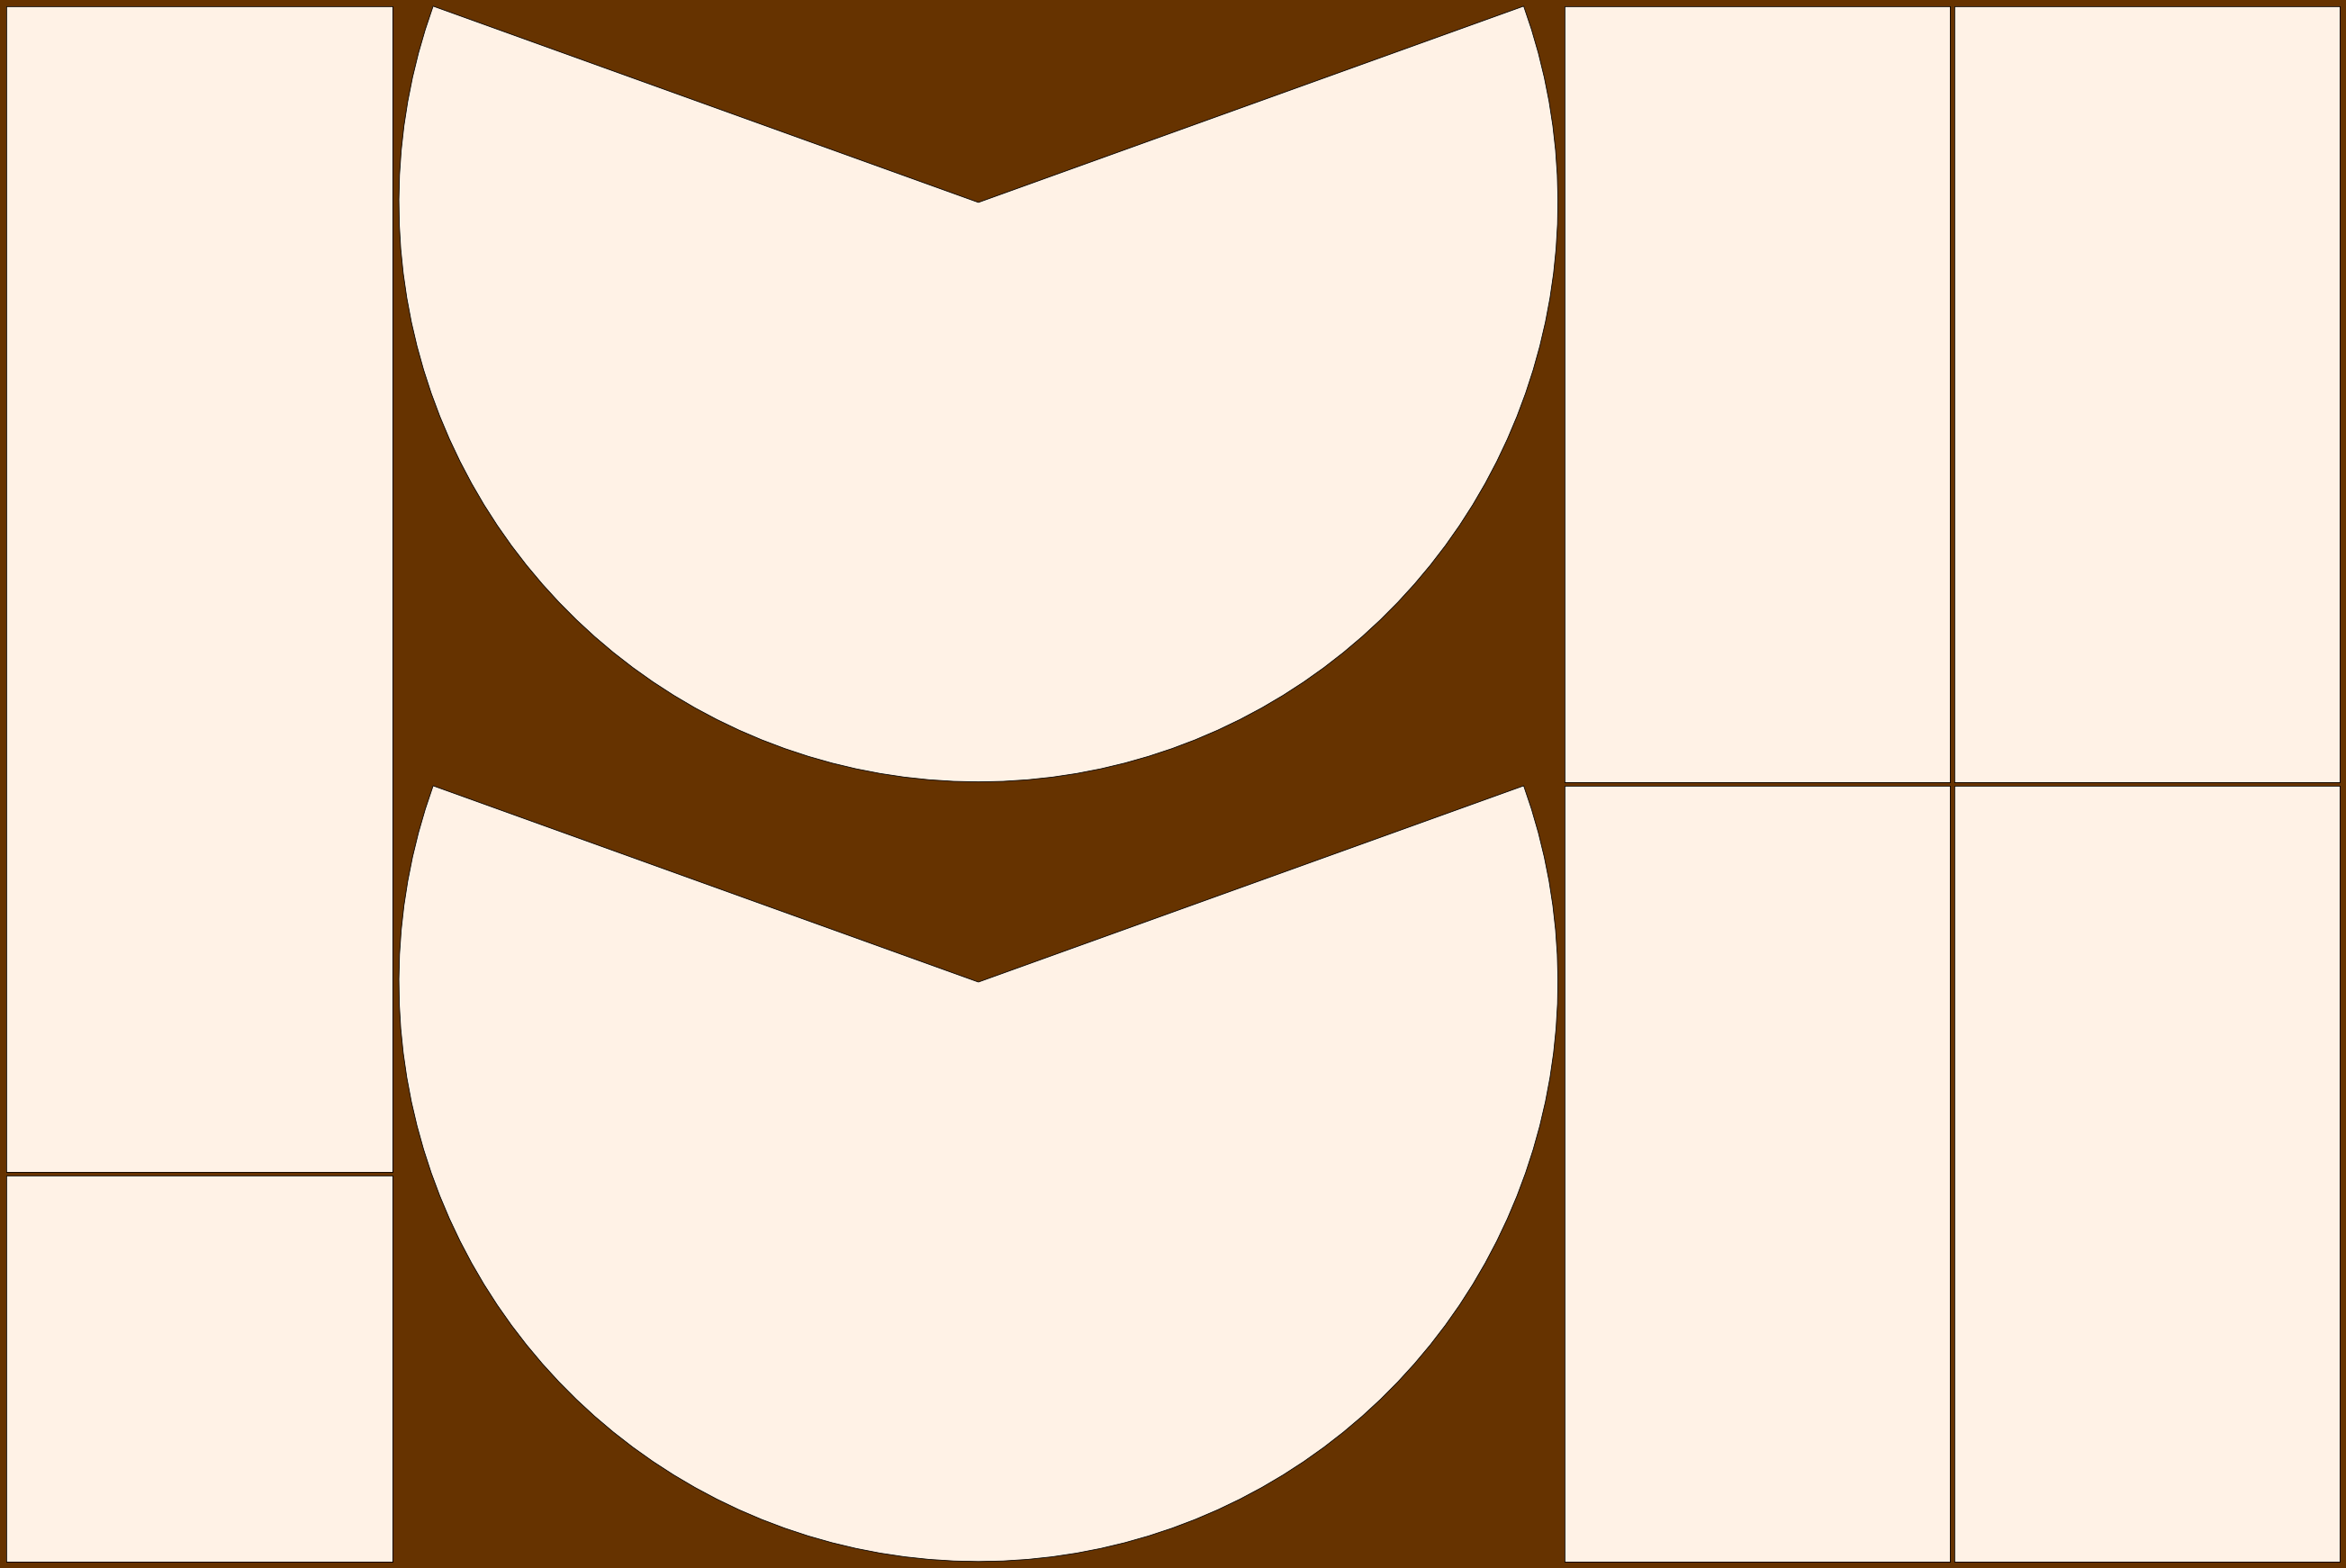

In [19]:
def draw_plot_foundation():
    
    ## make figure and grid objects
    global poster_fig
    poster_fig = plt.figure(figsize = (36, 24))
    poster_grid  = poster_fig.add_gridspec(4, 6, figure = poster_fig,
                                        hspace = 0.01, wspace = 0.01, top = 1,
                                        left = 0, right = 1, bottom = 0)
    poster_fig.set_facecolor(set_color['OrangeDark'])
    
    ## define axes
    global poster_ax
    poster_ax = dict()
    poster_ax['explain'] = poster_fig.add_subplot(poster_grid[0:3, 0:1])
    poster_ax['elbow']   = poster_fig.add_subplot(poster_grid[3:4, 0:1])

    poster_ax['income'] = poster_fig.add_subplot(poster_grid[0:2, 4:5])
    poster_ax['educ']   = poster_fig.add_subplot(poster_grid[2:4, 4:5])
    poster_ax['life']   = poster_fig.add_subplot(poster_grid[0:2, 5:6])
    poster_ax['gop']    = poster_fig.add_subplot(poster_grid[2:4, 5:6])
    
    poster_ax['map1'] = poster_fig.add_subplot(poster_grid[0:2, 1:4],
                                              projection = set_map['map_proj'])
    poster_ax['map2'] = poster_fig.add_subplot(poster_grid[2:4, 1:4],
                                              projection = set_map['map_proj'])
    
    ## remove axis ticks
    for i in poster_ax.keys():
        poster_ax[i].tick_params(
            bottom = False, top = False, left = False, right = False,
            labelbottom = False, labeltop = False, labelleft = False,
            labelright = False, color = 'red')
        poster_ax[i].set_facecolor(set_color['OrangeBG'])
        
## execute code
draw_plot_foundation()
log_time('RV0')

#### RV1 - draw explanation panel

#### RV2 - draw optimization 'elbow' curve

#### RV3 - draw cluster map (level 1)

In [20]:
## draw generic map layers
def draw_generic_map(ax):
    poster_ax[ax].set_extent(set_map['bounds'])
    poster_ax[ax].add_geometries(list(feature.STATES.geometries()),
        facecolor = '#33221100', edgecolor = set_color['OrangeLight'],
        lw = 1, zorder = 1, crs = PlateCarree())
    poster_ax[ax].add_feature(feature.LAKES,
        facecolor = '#33221100', edgecolor = set_color['OrangeLight'],
        lw = 1, zorder = 2)
    poster_ax[ax].add_feature(feature.OCEAN,
        facecolor = set_color['OrangeBG'], edgecolor = set_color['OrangeLight'],
        lw = 1, zorder = 4)

## draw the level one cluster boundaries
def draw_cluster_l1(ax, poly):
    
    first_poly = True
    for i in poly.keys():
        
        ## WARNING: THIS IS TEST CODE
        if first_poly:
            print('WARNING: THIS SEGMENT IS TEST CODE')
            poly_color = 'red'
            first_poly = False
        else:
            poly_color = set_color['AzureLight']
            
        poster_ax[ax].add_geometries(poly[i].geoms,
            facecolor = poly_color,
            edgecolor = set_color['AzureDark'],
            crs = PlateCarree(), zorder = 0)
    
## execute code
draw_generic_map('map1')
draw_cluster_l1('map1', clust_polys_l1)

#### RV4 - draw cluster map (level 2)

In [21]:
## execute code
draw_generic_map('map2')
draw_cluster_l1('map2', clust_polys_l1)

#### RV5 - income stats panel

#### RV6 - education stats panel

#### RV7 - life expectancy stats panel

#### RV8 - republican voters stats panel (2020 POTUS election)

# Footer

#### write poster to file

In [22]:
def save_poster():
    poster_fig.savefig('C_Output/pop_cluster_map.png')
    poster_fig.savefig('C_Output/pop_cluster_map.pdf')
save_poster()

In [23]:
## TODO: fix order scrambling problem with polygon selection
log_time()

Time log:
   H2: 10:06:44
   H3: 10:06:44
  GD1: 10:06:44
  RD1: 10:06:44
  RD2: 10:06:44
  RD3: 10:06:44
  MD1: 10:06:47
  MD2: 10:06:47
  MD3: 10:06:47
 CSS1: 10:06:47
 PVD1: 10:06:48
 PVD2: 10:06:48
  RV0: 10:06:48
  End: 10:06:55
